In [1]:
from functions import map_scatter, glasbey, analyze_slide_zoomed_out, analyze_slide
from matplotlib.ticker import LogLocator, ScalarFormatter, NullFormatter
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, ttest_rel
from google.cloud import storage
from scipy import stats
from scipy.spatial import Delaunay
from matplotlib.collections import PatchCollection
from sklearn.preprocessing import QuantileTransformer
from matplotlib.patches import Polygon
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
from anndata import AnnData
import pandas as pd
import numpy as np
import seaborn as sns
import colorcet as cc
import scanpy as sc
# import nfinder
import copy
import os

In [2]:
# read in data
data_path = "gs://mayo-nguyen-transplant/nduarte-csv/data.csv"
df = pd.read_csv(data_path)

In [3]:
df.columns

Index(['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm',
       'Centroid Y µm', 'DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67',
       'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68',
       'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14',
       'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1',
       'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e', 'Slide',
       'UMAP1', 'UMAP2', 'PC1_1', 'PC2_1', 'PC3_1', 'PC4_1', 'PC5_1', 'PC6_1',
       'PC7_1', 'PC8_1', 'PC9_1', 'PC10_1', 'PC1_hcorr', 'PC2_hcorr',
       'PC3_hcorr', 'PC4_hcorr', 'PC5_hcorr', 'PC6_hcorr', 'PC7_hcorr',
       'PC8_hcorr', 'PC9_hcorr', 'PC10_hcorr', 'UMAP1_hcorr', 'UMAP2_hcorr',
       'Leiden', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'Phenotype',
       'Timepoint'],
      dtype='object')

In [4]:
metadata = ['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm', 'Centroid Y µm', 'UMAP1_hcorr', 'UMAP2_hcorr', 'PC1_hcorr', 'PC2_hcorr', 'PC3_hcorr', 'PC4_hcorr', 'PC5_hcorr', 'PC6_hcorr', 'PC7_hcorr', 'PC8_hcorr', 'PC9_hcorr', 'PC10_hcorr', 'Leiden', 'Level 1', 'Level 2', 'Level 3',
       'Level 4', 'Phenotype', 'Timepoint']
markers = ['DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e']

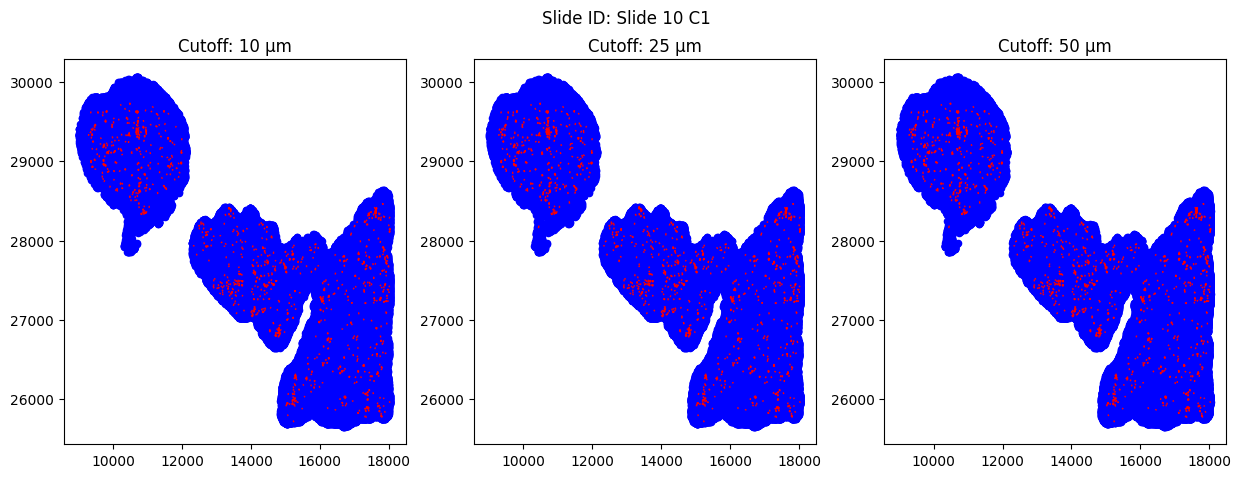

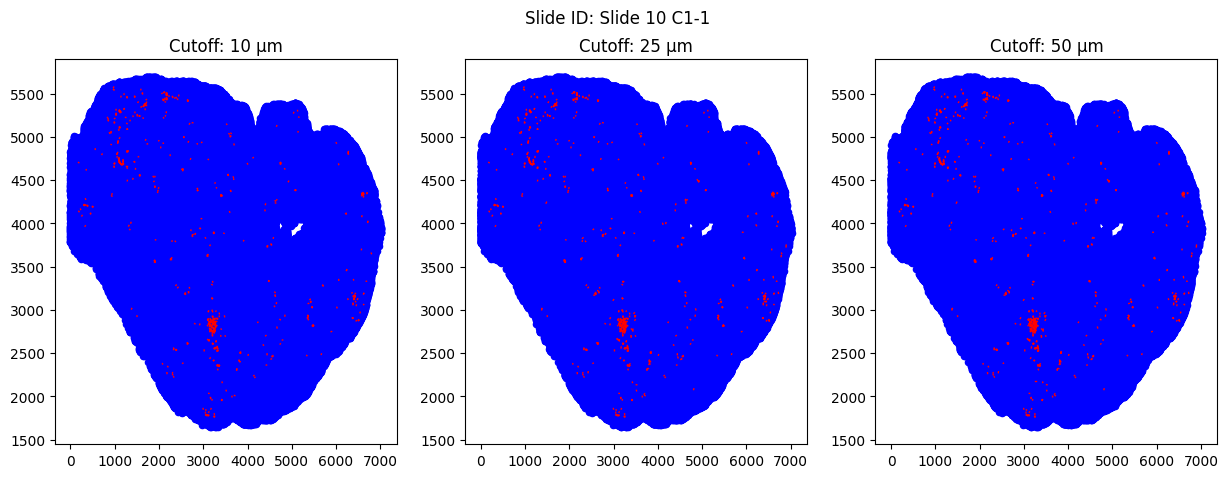

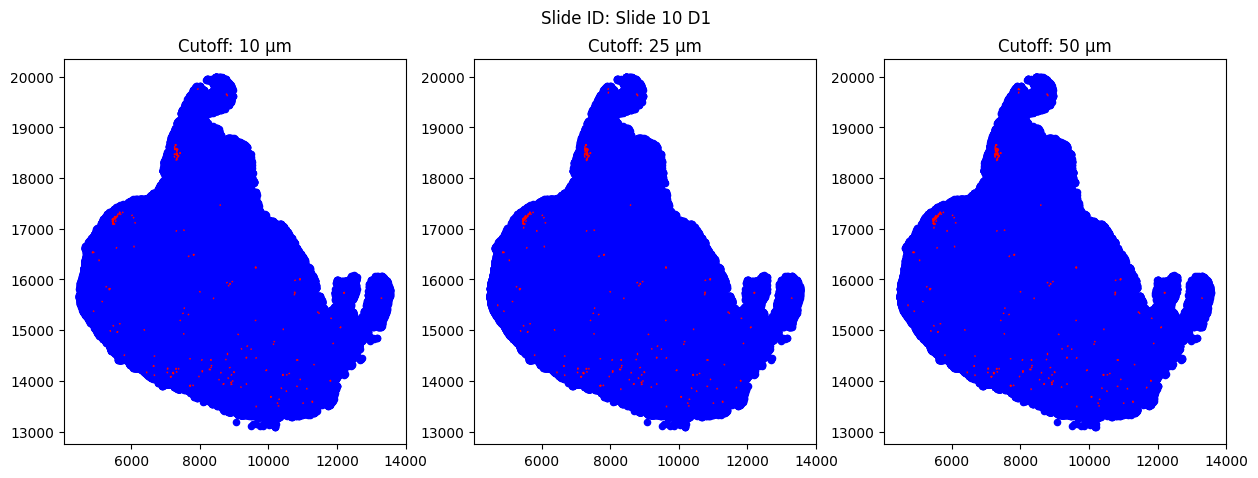

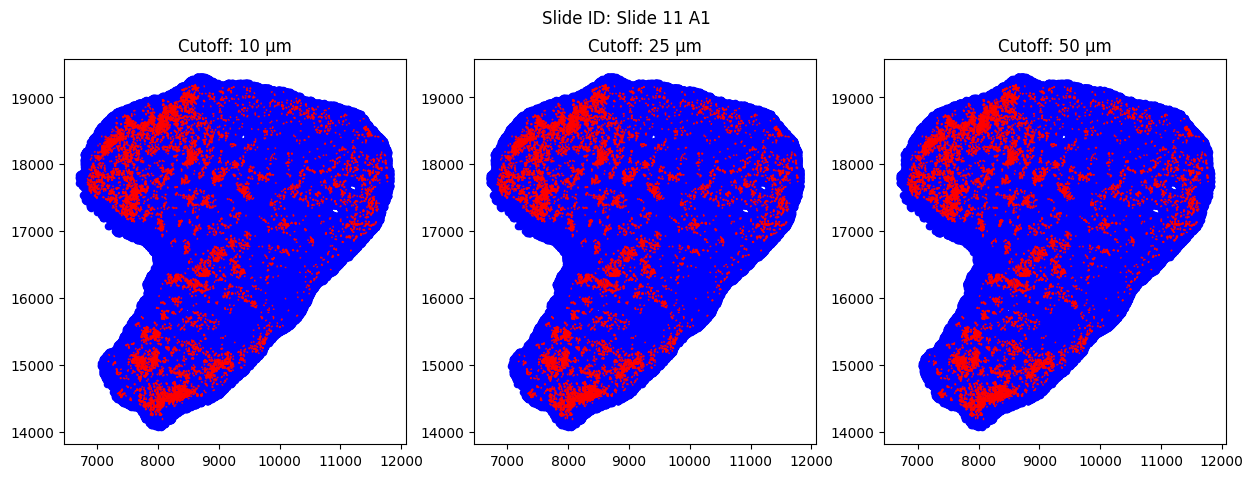

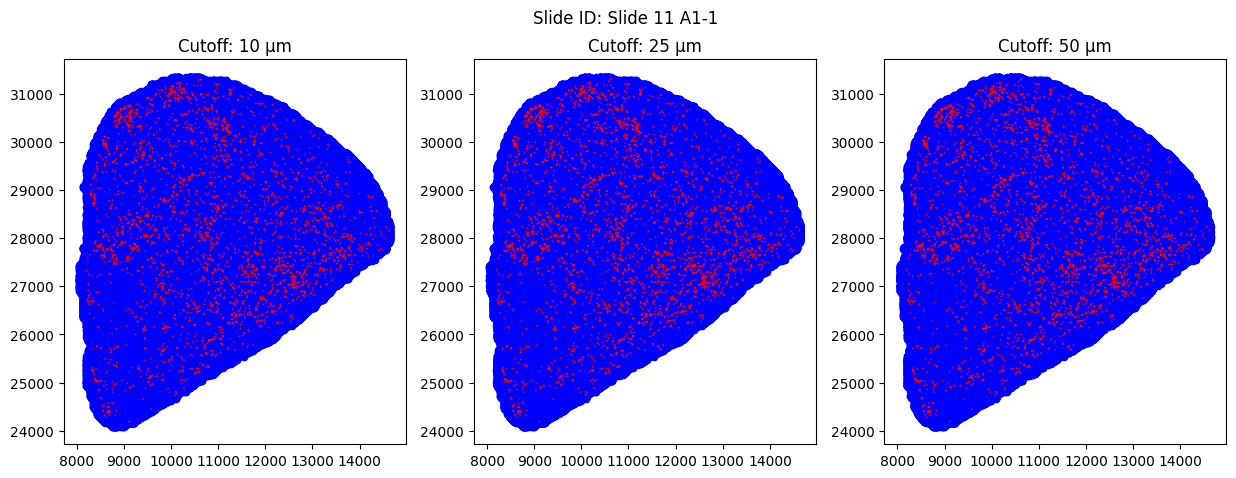

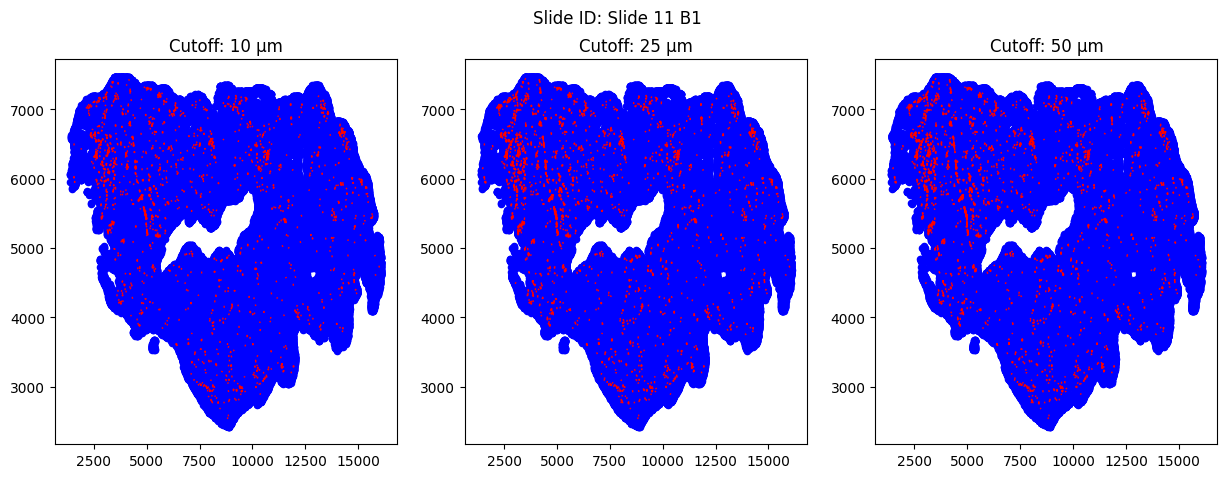

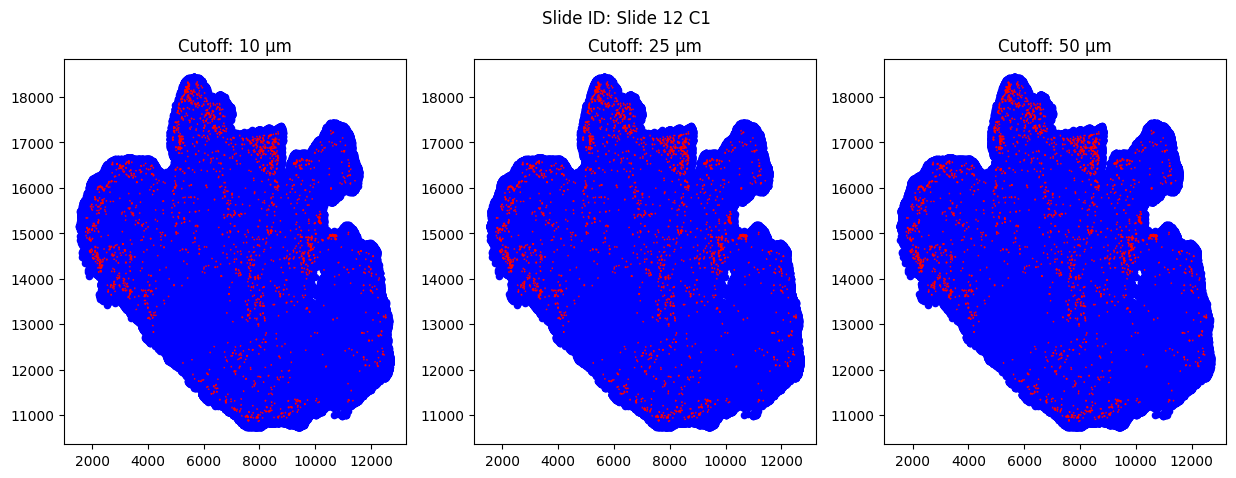

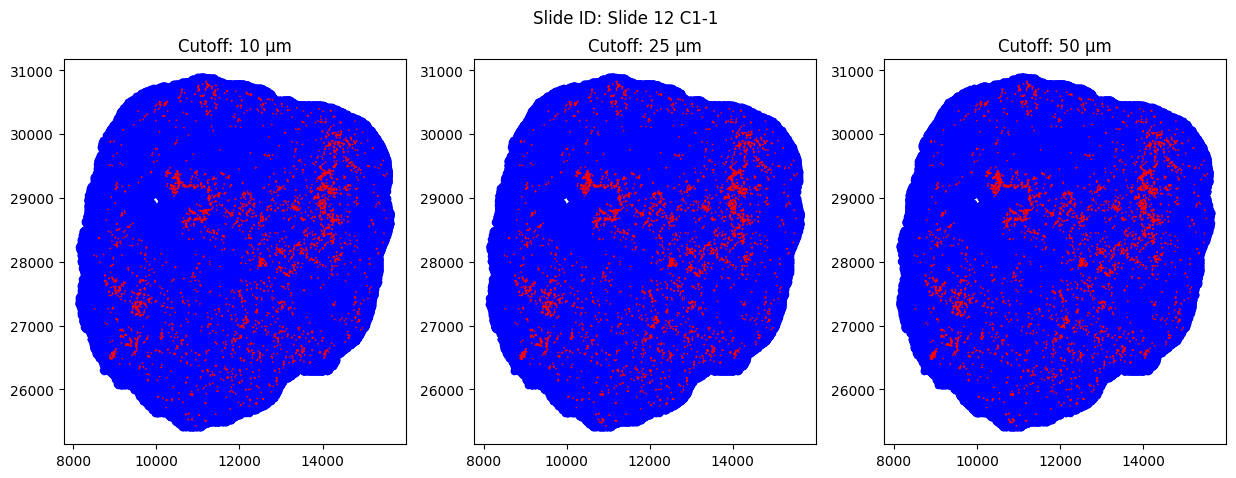

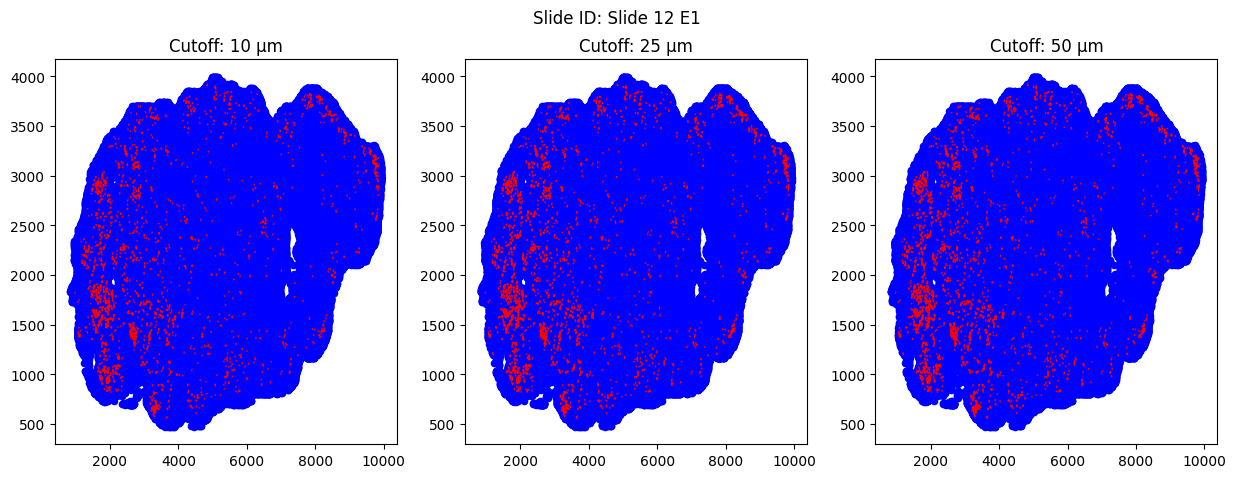

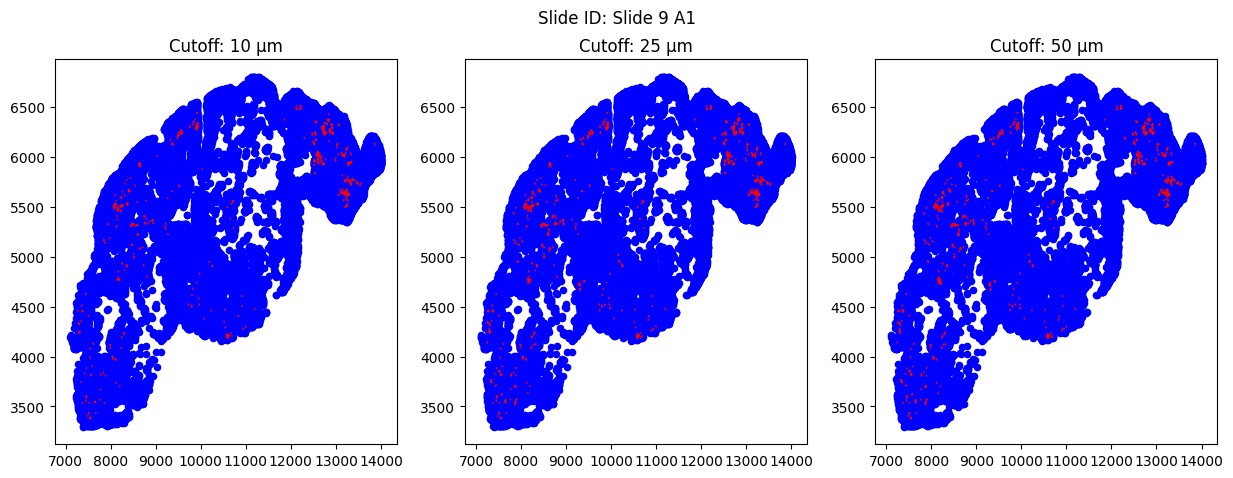

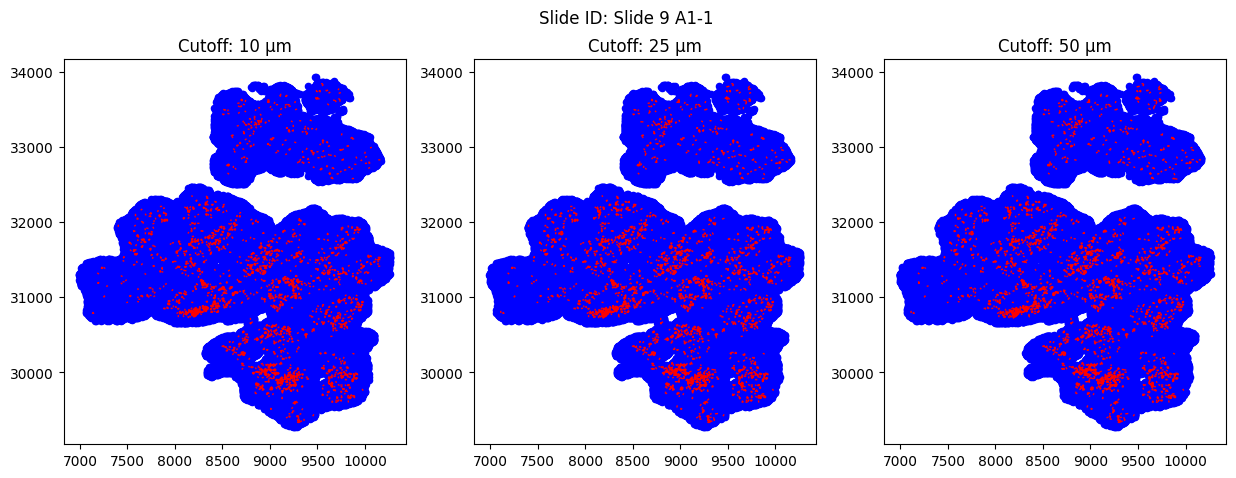

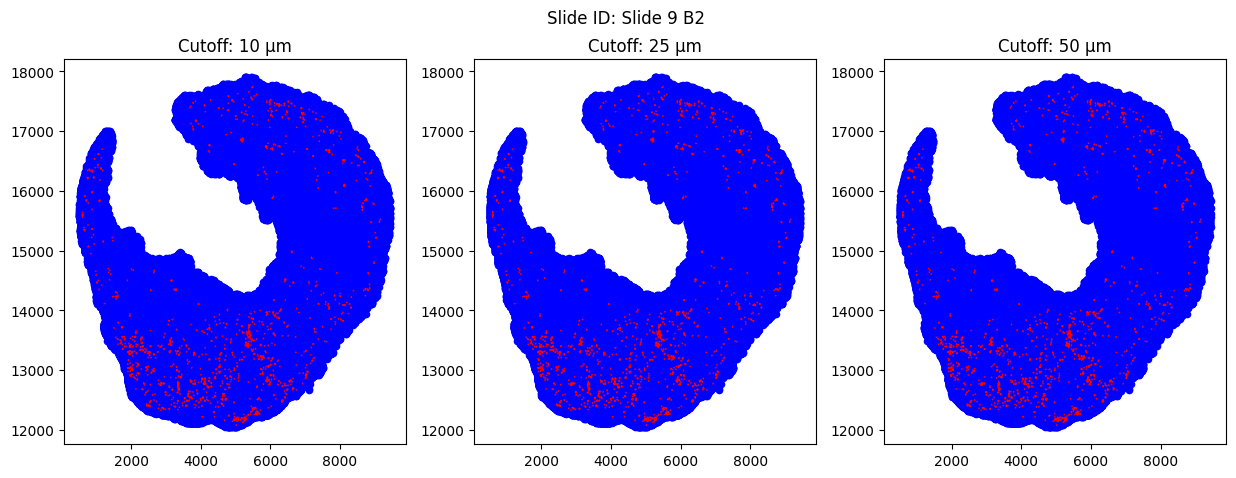

In [6]:
distance_cutoffs = [10, 25, 50]
phenotypes_interest = ['Mem Helper T', 'Inhib Monocyte', 'Th1 Helper T', 'Act Macrophage', 'Ant Pres Monocyte', 'Inhib Monocyte', 
 'Ant Pres Dendritic', 'NK Cell', 'Plasma B', 'B Cell']
analyze_slide_zoomed_out(df, distance_cutoffs, phenotypes_interest)

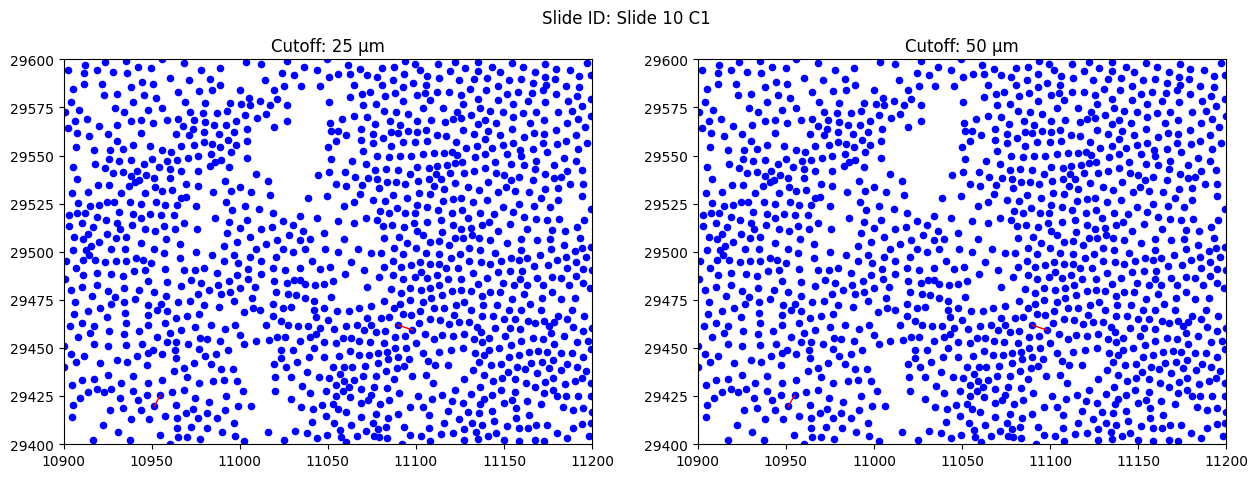

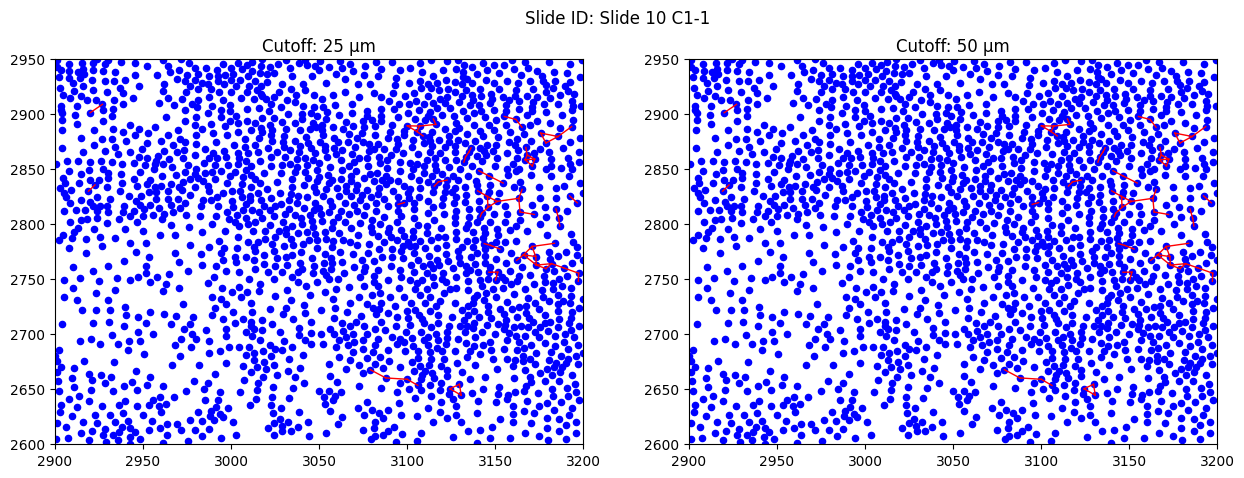

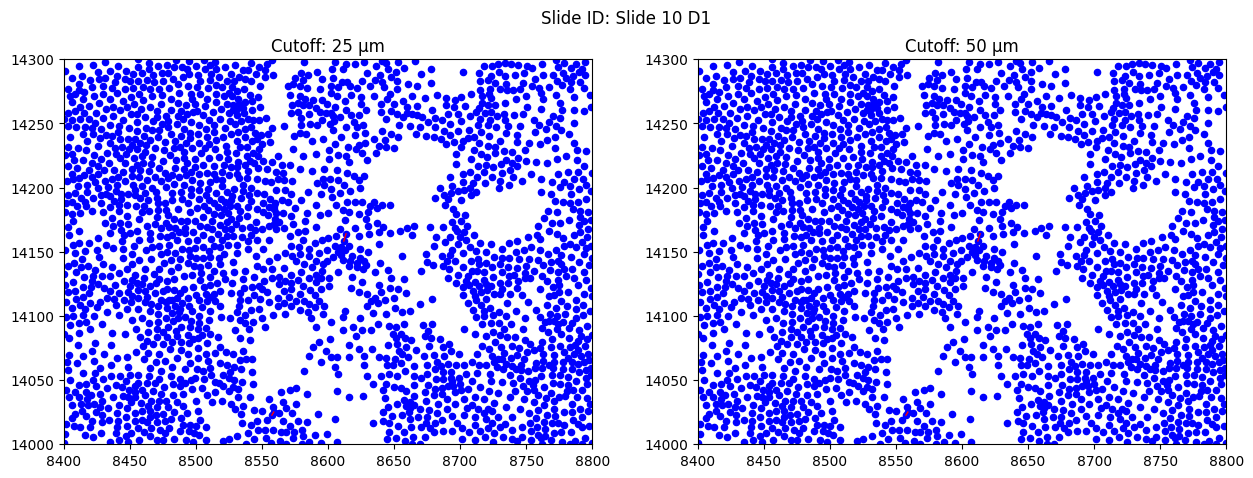

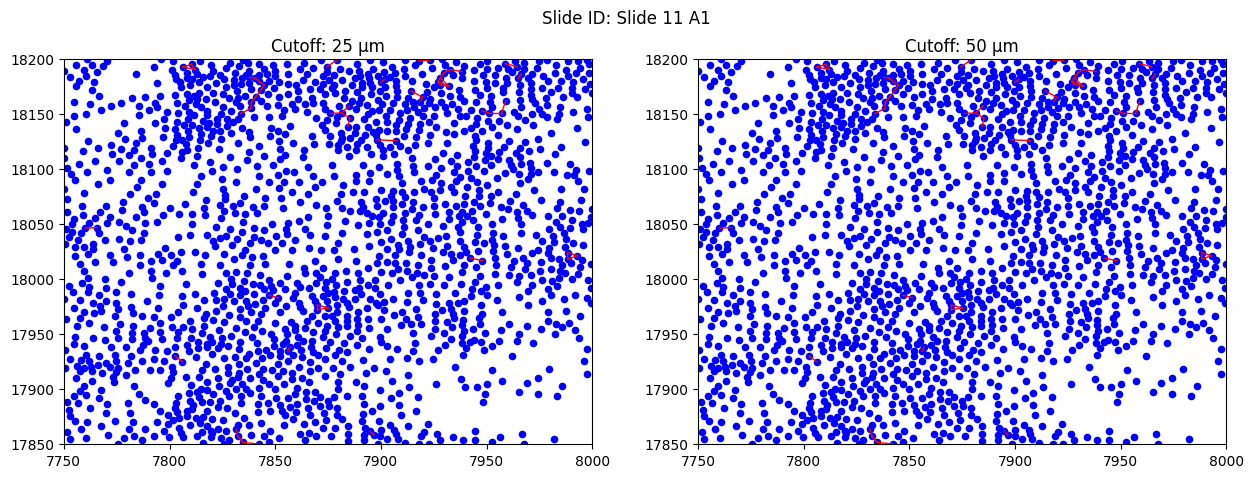

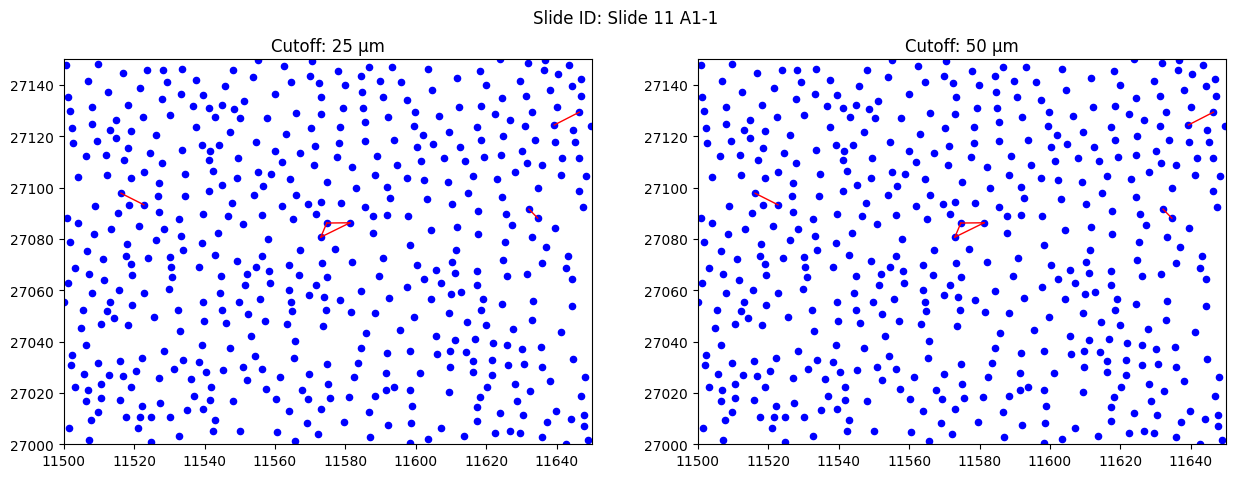

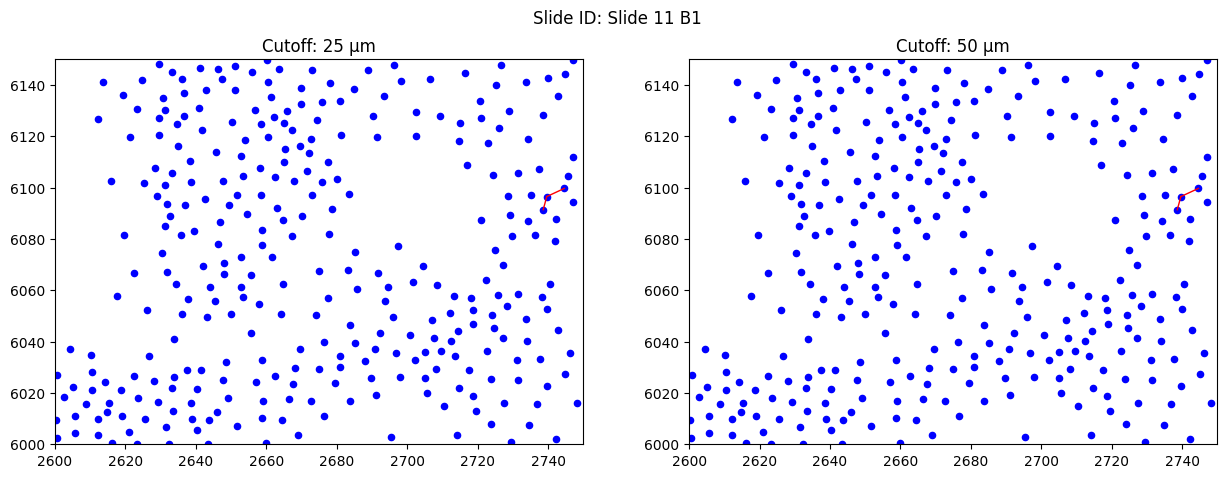

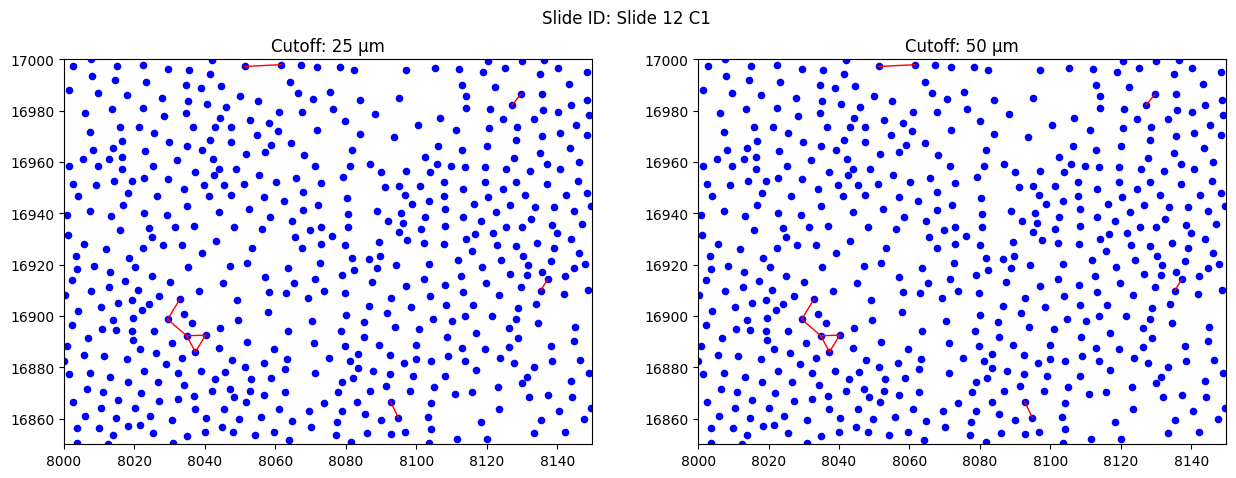

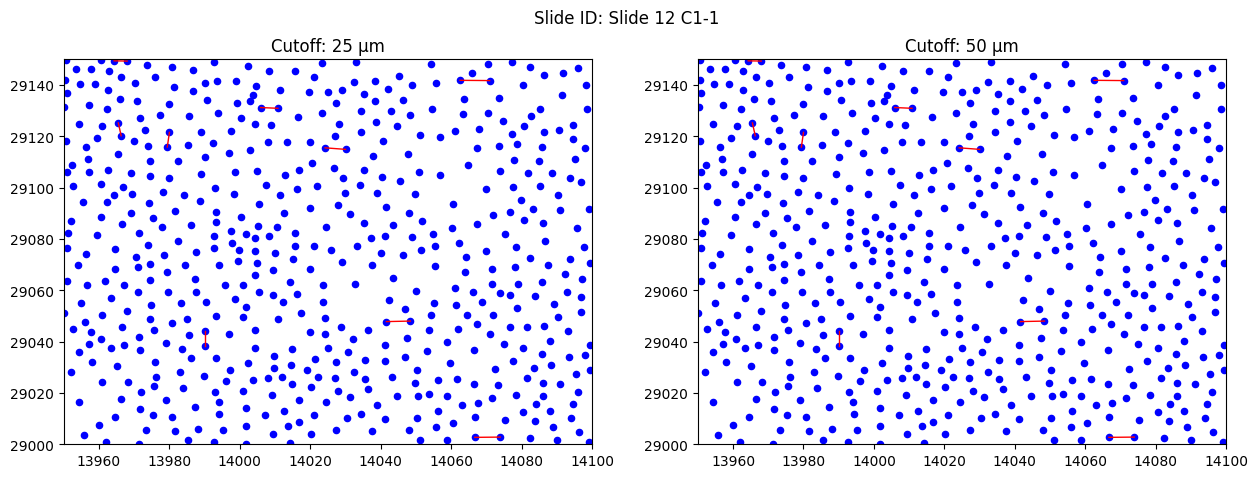

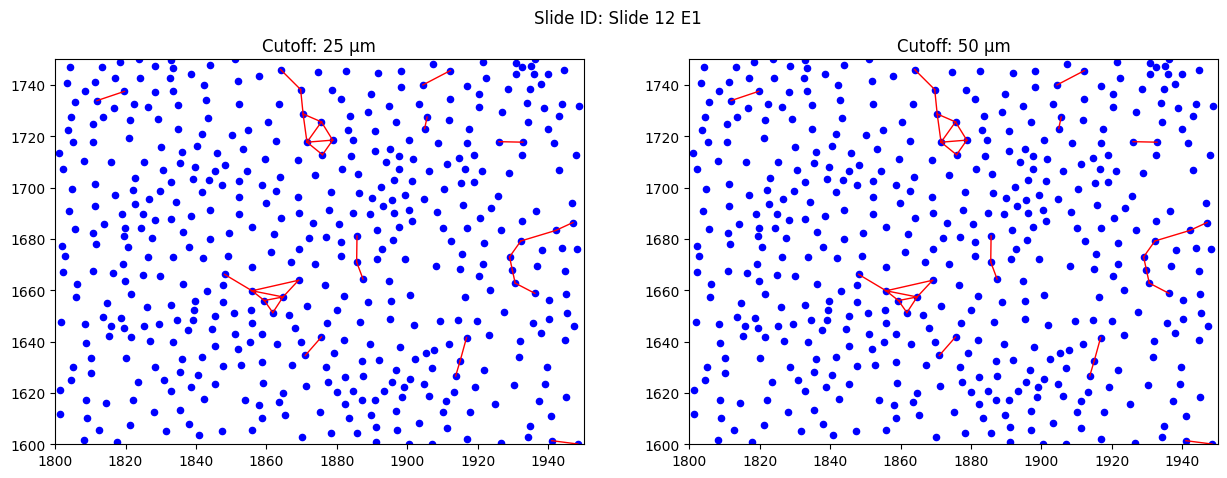

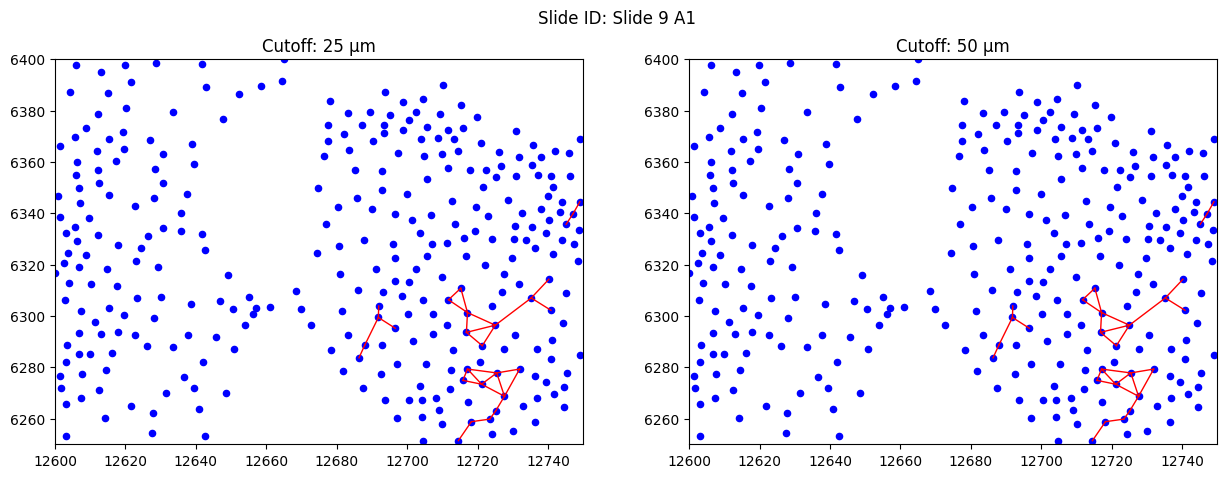

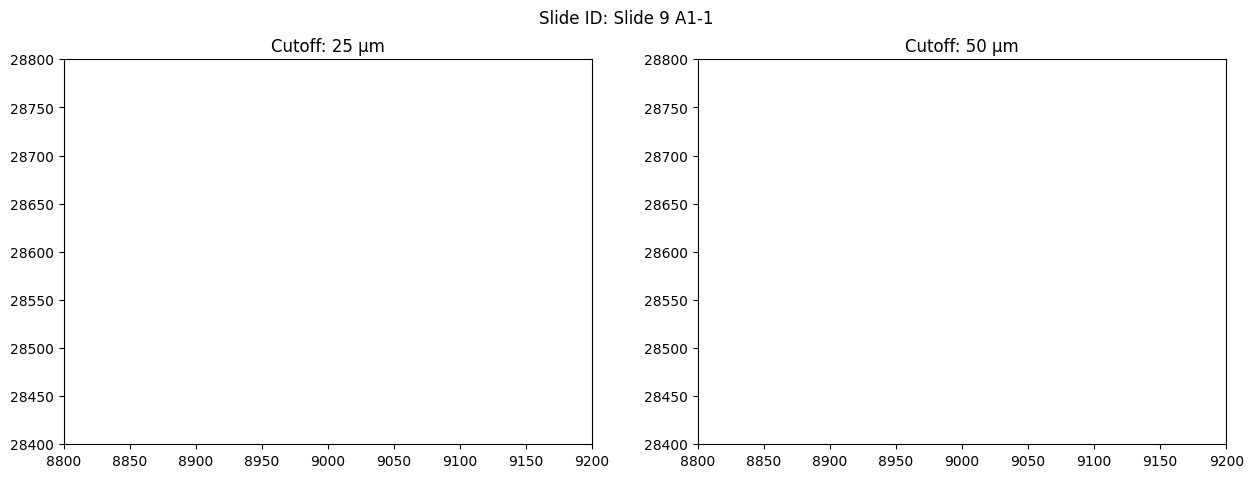

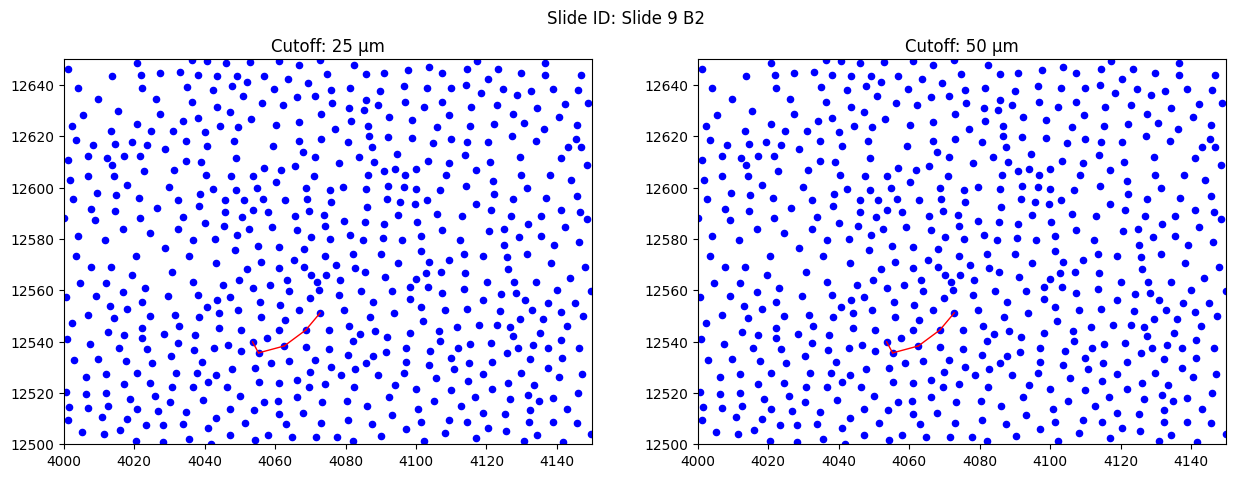

In [7]:
distance_cutoffs = [25, 50]
bounds = {'Slide 9 A1': (12600, 12750, 6250, 6400),
          'Slide 9 B2': (4000, 4150, 12500, 12650),
          'Slide 9 A1-1': (8800, 9200, 28400, 28800),
          'Slide 10 C1-1': (2900, 3200, 2600, 2950),
          'Slide 10 D1': (8400, 8800, 14000, 14300),
          'Slide 10 C1': (10900, 11200, 29400, 29600),
          'Slide 11 B1': (2600, 2750, 6000, 6150),
          'Slide 11 A1': (7750, 8000, 17850, 18200),
          'Slide 11 A1-1': (11500, 11650, 27000, 27150),
          'Slide 12 E1': (1800, 1950, 1600, 1750),
          'Slide 12 C1': (8000, 8150, 16850, 17000),
          'Slide 12 C1-1': (13950, 14100, 29000, 29150),
          }
analyze_slide(df, distance_cutoffs, phenotypes_interest, bounds)